<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import matplotlib.dates as mdate
from matplotlib import ticker

In [3]:
plt.rcParams["figure.figsize"] = (10,8)

In [4]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [5]:
import lightgbm as lgbm

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [7]:
from statsmodels.tsa.stattools import adfuller

In [8]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0],
parse_dates=[0])


In [9]:
RANDOM_STATE = 42

## Подготовка

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


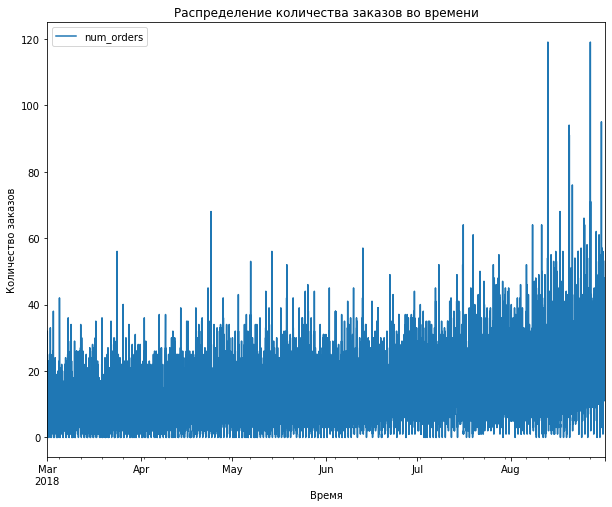

In [10]:
df.plot()
df.info()
plt.title('Распределение количества заказов во времени')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.show()

In [11]:
# ресемплинг - среднее по каждому часу
df = df.resample('1H').sum()

num_orders    0
dtype: int64


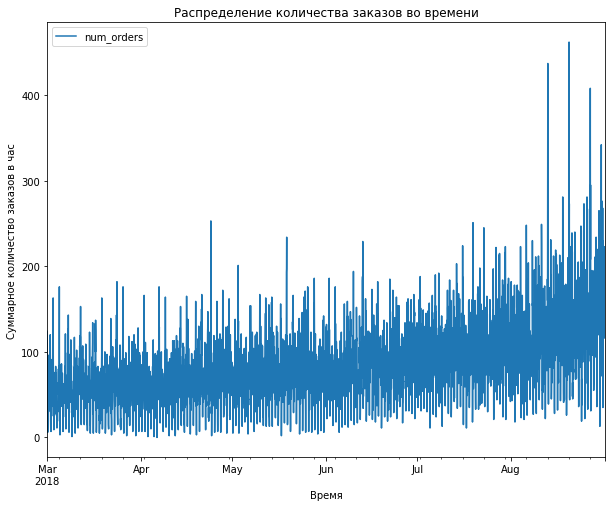

In [12]:
print(df.isna().sum())
df.plot()
df.head()
plt.title('Распределение количества заказов во времени')
plt.xlabel('Время')
plt.ylabel('Суммарное количество заказов в час')
plt.show()

**Выводы**: уже после ресепмлирования видно, что среднее количество заказов в час повысилось с марта по сентябрь. Это может быть обусловено как сезонностью (например, летом всегда повышается количетсво заказов из аэропорта в связи с отпусками), так и общим трендом заказов такси (например, улучшение экономической ситуации - повышение доступности сервиса), но об этом на этих данных пока судить сложно.

## Анализ

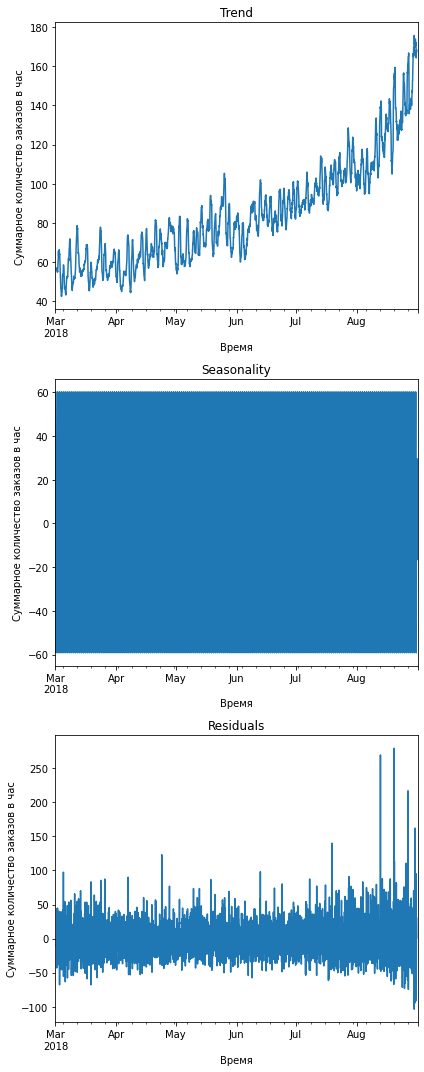

In [13]:
#Посмотрим на график тренда, сезонности и шума

decomposed = seasonal_decompose(df)

plt.figure(figsize=(6, 15))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.xlabel('Время')
plt.ylabel('Суммарное количество заказов в час')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.xlabel('Время')
plt.ylabel('Суммарное количество заказов в час')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.xlabel('Время')
plt.ylabel('Суммарное количество заказов в час')
plt.tight_layout();

Явно виден общий тренд на повышение количества заказов с марта по август

Теперь посмотрим сезонную компоненту на меньшем промежутке времени для лучшего понимания сезонности.
Сначала возьмем данные за месяц.

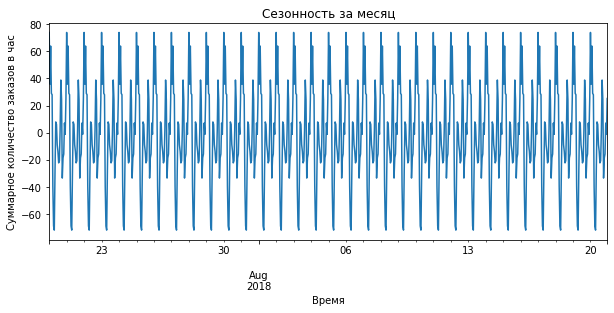

In [14]:
df_month = df['2018-07-20':'2018-08-20']
decomposed_month = seasonal_decompose(df_month)

plt.figure(figsize=(10, 4))
decomposed_month.seasonal.plot()
plt.title('Сезонность за месяц')
plt.xlabel('Время')
plt.ylabel('Суммарное количество заказов в час')
plt.show()

Похоже, у нас нет месячной и недельной сезонности (например, заказов могло бы быть больше в пятницу или по выходным), зато уже видна суточная сезонность. Посмотрим на нее поближе.

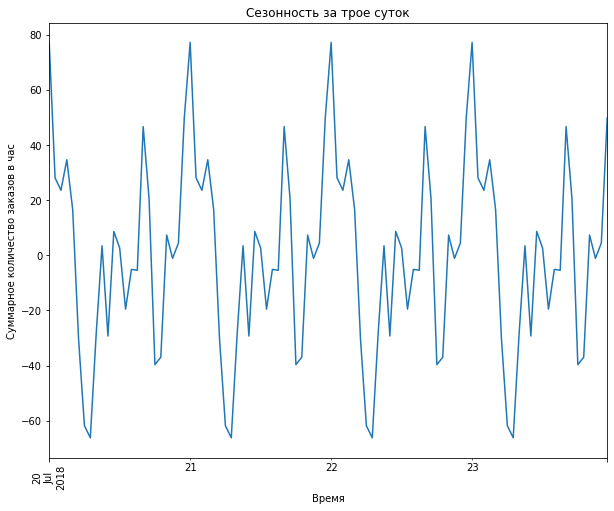

In [15]:
df_month = df['2018-07-20':'2018-07-23']
decomposed_month = seasonal_decompose(df_month)
decomposed_month.seasonal.plot()
plt.title('Сезонность за трое суток')
plt.xlabel('Время')
plt.ylabel('Суммарное количество заказов в час')
plt.xticks(rotation=90)
plt.show()

Определенно видна суточная сезонность, посмотрим на пики и спады в течении одних суток.

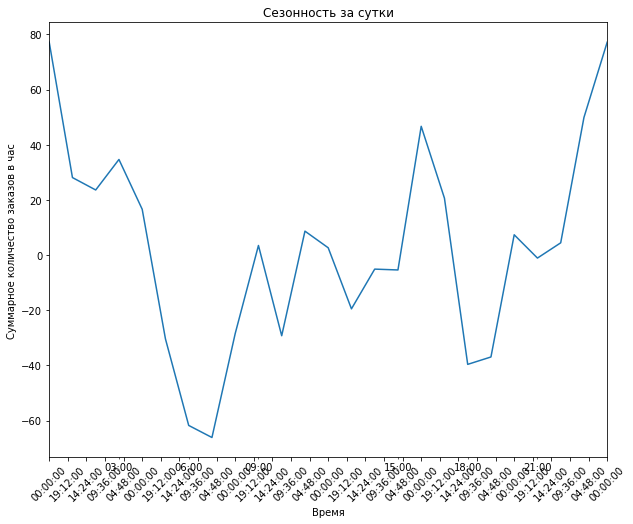

In [16]:
tick_spacing = 0.8
time_fmt = '%H:%M:%S'
fig, ax = plt.subplots()
decomposed_month.seasonal['2018-07-20 00:00:00':'2018-07-21 00:00:00'].plot()
plt.title('Сезонность за сутки')
plt.xticks(rotation=45)
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax.xaxis.set_major_formatter(mdate.DateFormatter(time_fmt))
plt.xlabel('Время')
plt.ylabel('Суммарное количество заказов в час')
plt.show()

In [17]:
decomposed_month.seasonal['2018-07-20 00:00:00':'2018-07-21 00:00:00'].sort_values()

datetime
2018-07-20 07:00:00   -66.154803
2018-07-20 06:00:00   -61.779803
2018-07-20 18:00:00   -39.640914
2018-07-20 19:00:00   -36.960359
2018-07-20 05:00:00   -30.404803
2018-07-20 10:00:00   -29.258970
2018-07-20 08:00:00   -28.474248
2018-07-20 13:00:00   -19.508970
2018-07-20 15:00:00    -5.411748
2018-07-20 14:00:00    -5.106192
2018-07-20 21:00:00    -1.099248
2018-07-20 12:00:00     2.629919
2018-07-20 09:00:00     3.463252
2018-07-20 22:00:00     4.428530
2018-07-20 20:00:00     7.345197
2018-07-20 11:00:00     8.664641
2018-07-20 04:00:00    16.588252
2018-07-20 17:00:00    20.616030
2018-07-20 02:00:00    23.588252
2018-07-20 01:00:00    28.088252
2018-07-20 03:00:00    34.650752
2018-07-20 16:00:00    46.671586
2018-07-20 23:00:00    49.879919
2018-07-20 00:00:00    77.185475
2018-07-21 00:00:00    77.185475
Name: seasonal, dtype: float64

**Выводы о сезонности:**
    
Мы видим явную суточную сезонность, с пиками в 00:00 (самый крупный пик), 23:00 и 16:00 и спадами в 7:00, 6:00 и 18:00, 19:00. Скорее всего, это связано со временем прилета самых популярных рейсов (вечерних, на которые можно успеть "после работы" и утренних, прилетающих днем) и самых непопулярных рейсов (ночных и "посреди дня").

Используем информацию о сезонности в дальнейшем при создании признаков для обучения модели.

-----------------------------
Далее посмотрим на стационарность ряда.

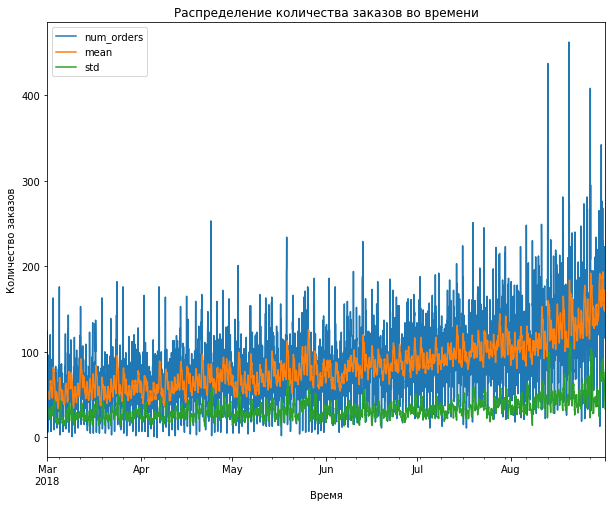

In [18]:
#Посмотрим на скользящее среднее и стандартное отклонение

df['mean'] = df['num_orders'].shift().rolling(15).mean()
df['std'] = df['num_orders'].shift().rolling(15).std()
df.plot() 
plt.title('Распределение количества заказов во времени')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.show()

**Вывод:** Скользящее среднее показывает тот же тренд на повышение числа заказов, при этом скользящее стандартное отклонение остается примерно на одном уровне за исключением периода августа, где разброс значений больше, чем в предыдущие месяцы.

Скользящее среднее растет, значит ряд скорее всего не станционарный. Чтобы проверить это, проведем оценку с помощью теста Дики-Фуллера.

Гипотезы для теста:

Нулевая - ряд нестанционарен <br>
Альтернативная - ряд стационарен

In [19]:
result = adfuller(df['num_orders'], autolag='AIC')

print('Критерий ADF: %f' % result[0])

print('P-значение: %f' % result[1])

print('Критические значения:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

print('При пороговом значении 0.01:')
if result[0] < result[4]["1%"]:
    print ("Нулевая гипотеза отвергнута – Временной ряд стационарен")
else:
    print ("Нулевая гипотеза не отвергнута – Временной ряд не стационарен")
    
print('При пороговом значении 0.05:')
if result[0] < result[4]["5%"]:
    print ("Нулевая гипотеза отвергнута – Временной ряд стационарен")
else:
    print ("Нулевая гипотеза не отвергнута – Временной ряд не стационарен")

Критерий ADF: -3.068924
P-значение: 0.028940
Критические значения:
	1%: -3.432
	5%: -2.862
	10%: -2.567
При пороговом значении 0.01:
Нулевая гипотеза не отвергнута – Временной ряд не стационарен
При пороговом значении 0.05:
Нулевая гипотеза отвергнута – Временной ряд стационарен


**Вывод о стационарности ряда по тесту Дики-Фуллера**:

Таким образом, при выставлении порога p-value в 0.05 наш ряд проходит проверку, однако при пороге 0.01 мы не можем отвергнуть нулевую гипотезу. 

In [20]:
#Создадим наши признаки
def make_features(data, max_lag, rolling_mean_size):
    df_foo = data.copy()
    df_foo['hour'] = df_foo.index.hour
    df_foo['day'] = df_foo.index.day
    df_foo['dayofweek'] = df_foo.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df_foo['lag_{}'.format(lag)] = df_foo['num_orders'].shift(lag)

    df_foo['rolling_mean'] = df_foo['num_orders'].shift().rolling(rolling_mean_size).mean()
    return df_foo

In [21]:
df_foo = make_features(df, 5, 15)

In [22]:
df_foo.drop(['mean', 'std'], axis = 1, inplace = True)
df_foo.head()

,num_orders,hour,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean
datetime,,,,,,,,,,
2018-03-01 00:00:00,124,0,1,3,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,1,3,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,1,3,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,71.0,85.0,124.0,NaN,NaN,NaN
2018-03-01 04:00:00,43,4,1,3,66.0,71.0,85.0,124.0,NaN,NaN


In [23]:
df_foo.dropna(inplace = True)

## Обучение

In [25]:
features = df_foo.drop('num_orders', axis = 1)
target = df_foo['num_orders']
features_train, features_test, target_train, target_test = train_test_split(features,target, test_size=0.1, shuffle = False, random_state=RANDOM_STATE)

In [26]:
features_train.head()

,hour,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean
datetime,,,,,,,,,
2018-03-01 15:00:00,15,1,3,48.0,32.0,30.0,96.0,64.0,53.000000
2018-03-01 16:00:00,16,1,3,66.0,48.0,32.0,30.0,96.0,49.133333
2018-03-01 17:00:00,17,1,3,43.0,66.0,48.0,32.0,30.0,46.333333
2018-03-01 18:00:00,18,1,3,44.0,43.0,66.0,48.0,32.0,44.533333
2018-03-01 19:00:00,19,1,3,73.0,44.0,43.0,66.0,48.0,45.000000


In [46]:
#словари параметров для гридсерчей
param_grid_dt = {'max_depth': [None] + [i for i in range(2, 7)]}
param_grid_gb = {"max_depth": [None] + [i for i in range(2, 7)],
    "num_leaves": range(10, 100, 10)}
param_grid_rf = {'max_depth': [None] + [i for i in range(2, 7)], 'n_estimators':(20, 80, 20)}

In [33]:
param_grid_lr = {}

In [34]:
tscv = TimeSeriesSplit(n_splits=5)

In [35]:
%%time
lr_search = GridSearchCV(linear_model.LinearRegression(), cv = tscv, param_grid = param_grid_lr, \
                         scoring = 'neg_root_mean_squared_error')
lr_search.fit(features_train, target_train)

print('Время обучения линейной регресии:')
#lr_search.cv_results_

Время обучения линейной регресии:
CPU times: user 37.9 ms, sys: 13.6 ms, total: 51.5 ms
Wall time: 30 ms


In [36]:
print('RMSE линейной регресии на обучающей выборке на кросс-валидации:', lr_search.best_score_*(-1))

RMSE линейной регресии на обучающей выборке на кросс-валидации: 32.484244957576244


In [37]:
dt_search = GridSearchCV(DecisionTreeRegressor(random_state = RANDOM_STATE), cv = tscv, param_grid = param_grid_dt,\
                         scoring = 'neg_root_mean_squared_error')

In [38]:
%%time
dt_search.fit(features_train, target_train)
dt_search.cv_results_
print('Время обучения дерева решений:')

Время обучения дерева решений:
CPU times: user 297 ms, sys: 0 ns, total: 297 ms
Wall time: 295 ms


In [39]:
print('RMSE дерева решений на обучающей выборке на кросс-валидации:', dt_search.best_score_*(-1))

RMSE дерева решений на обучающей выборке на кросс-валидации: 30.34816805660187


In [47]:
%%time
rf_search = GridSearchCV(RandomForestRegressor(random_state = RANDOM_STATE), cv = tscv, param_grid = param_grid_rf,\
                         scoring = 'neg_root_mean_squared_error')
rf_search.fit(features_train, target_train)
rf_search.cv_results_
print('Время обучения случайного леса:')

Время обучения случайного леса:
CPU times: user 17 s, sys: 66.1 ms, total: 17 s
Wall time: 17.1 s


In [48]:
print('RMSE случайного леса на обучающей выборке на кросс-валидации:', rf_search.best_score_*(-1))

RMSE случайного леса на обучающей выборке на кросс-валидации: 25.84690277632821


In [49]:
%%time
gb_search = GridSearchCV(lgbm.LGBMRegressor(random_seed=RANDOM_STATE), cv = tscv, \
                         param_grid = param_grid_dt, scoring = 'neg_root_mean_squared_error')
gb_search.fit(features_train, target_train)
gb_search.cv_results_
print('Время обучения градиентного бустинга:')

Время обучения градиентного бустинга:
CPU times: user 2min 14s, sys: 980 ms, total: 2min 15s
Wall time: 2min 15s


In [50]:
print('RMSE градиентного бустинга на обучающей выборке на кросс-валидации:', gb_search.best_score_*(-1))

RMSE градиентного бустинга на обучающей выборке на кросс-валидации: 25.929971869241506


**Вывод по обучению моделей:**
    
Лучше всего на кросс-валидации себя показал случайный лес - его и будем использовать для тестирования на тестовых данных.

## Тестирование

In [53]:
rf_rmse_test = mean_squared_error(rf_search.best_estimator_.predict(features_test),\
                                  target_test)**0.5
print('RMSE случайного леса на обучающей выборке:', rf_rmse_test)

RMSE случайного леса на обучающей выборке: 45.92769241796285


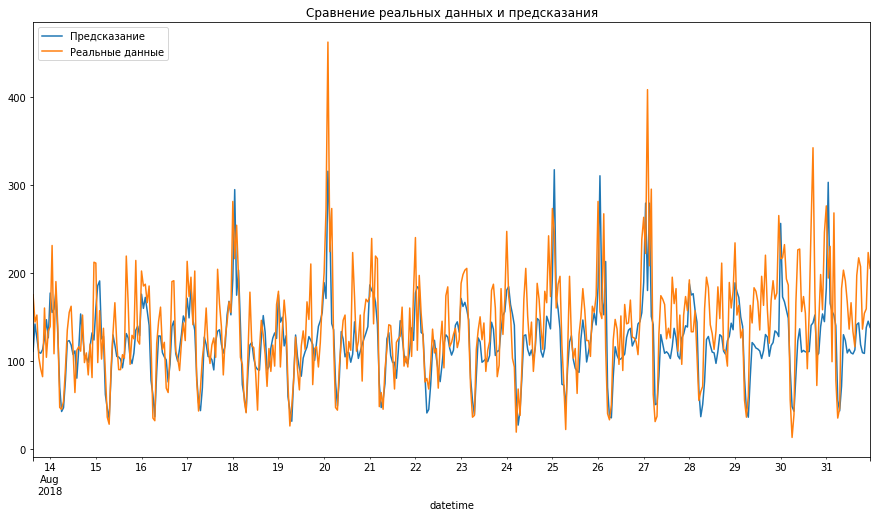

In [56]:
plt.figure(figsize=(15, 8))
pd.Series(rf_search.best_estimator_.predict(features_test),\
          index = target_test.index).plot(label="Предсказание")
target_test.plot(label="Реальные данные")
plt.title('Сравнение реальных данных и предсказания')
plt.legend(loc="upper left")
plt.show()

In [57]:
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]
pred_rmse=round(mean_squared_error(target_test, pred_previous)**0.5, 1)
print('RMSE для проверки модели на адекватность:', pred_rmse)

RMSE для проверки модели на адекватность: 58.9
